# **Data Prepare**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [ ]:
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
#!pip install --upgrade kornia > /dev/null
#!pip install allennlp==1.1.0.rc4 > /dev/null
#!pip install --upgrade fastai > /dev/null
import fastai; fastai.__version__

'2.7.12'

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/content/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename))

for dirname, _, filenames in os.walk('/content/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
36,/content/liver-tumor-segmentation/segmentations,segmentation-11.nii
18,/content/liver-tumor-segmentation/segmentations,segmentation-110.nii
8,/content/liver-tumor-segmentation/segmentations,segmentation-111.nii
13,/content/liver-tumor-segmentation/segmentations,segmentation-112.nii
27,/content/liver-tumor-segmentation/segmentations,segmentation-113.nii
...,...,...
91,/content/liver-tumor-segmentation-part-2/volume_pt6,volume-91.nii
77,/content/liver-tumor-segmentation-part-2/volume_pt6,volume-92.nii
80,/content/liver-tumor-segmentation-part-2/volume_pt6,volume-93.nii
83,/content/liver-tumor-segmentation-part-2/volume_pt6,volume-94.nii


In [ ]:
# Map CT scan and label

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)
print(len(df_files))
df_files

46


,dirname,filename,mask_dirname,mask_filename
0,/content/liver-tumor-segmentation/volume_pt2,volume-11.nii,/content/liver-tumor-segmentation/segmentations,segmentation-11.nii
1,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-110.nii,/content/liver-tumor-segmentation/segmentations,segmentation-110.nii
2,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-111.nii,/content/liver-tumor-segmentation/segmentations,segmentation-111.nii
3,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-112.nii,/content/liver-tumor-segmentation/segmentations,segmentation-112.nii
4,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-113.nii,/content/liver-tumor-segmentation/segmentations,segmentation-113.nii
5,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-114.nii,/content/liver-tumor-segmentation/segmentations,segmentation-114.nii
6,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-115.nii,/content/liver-tumor-segmentation/segmentations,segmentation-115.nii
7,/content/liver-tumor-segmentation/volume_pt2,volume-12.nii,/content/liver-tumor-segmentation/segmentations,segmentation-12.nii
8,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-120.nii,/content/liver-tumor-segmentation/segmentations,segmentation-120.nii
9,/content/liver-tumor-segmentation-part-2/volume_pt8,volume-121.nii,/content/liver-tumor-segmentation/segmentations,segmentation-121.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample
sample = 1
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 816), (512, 512, 816))

In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-2048.0 7249.0
0.0 2.0


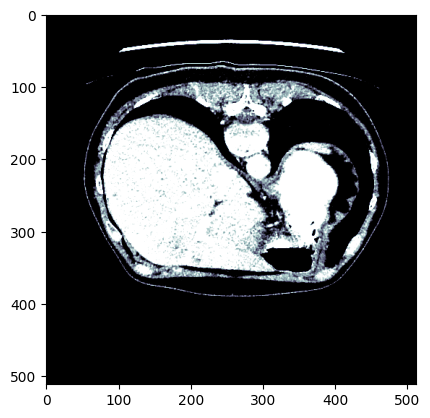

In [ ]:
# Preprocess the nii file

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,480].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')

    plt.show()


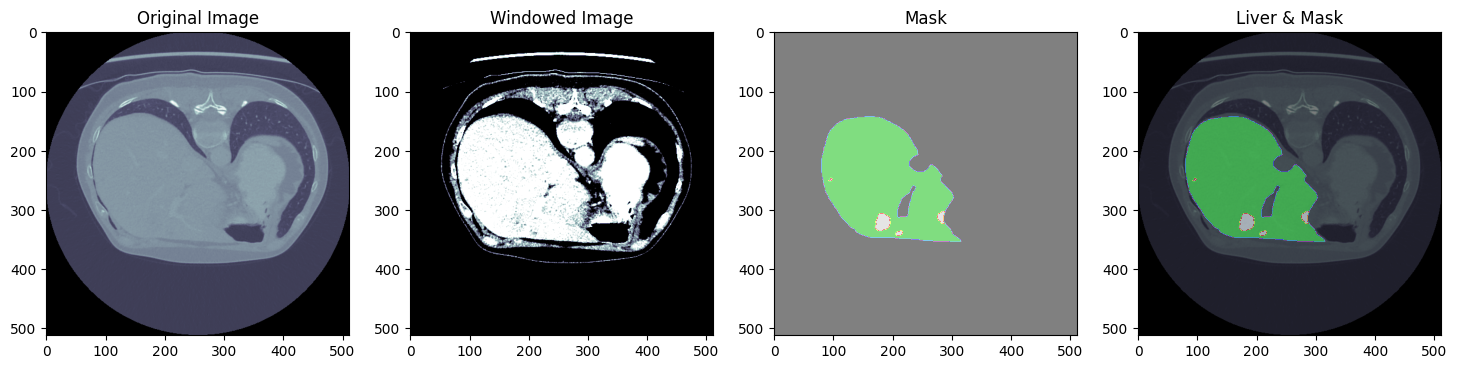

In [ ]:
sample=480
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [ ]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 229057]
 [     1  32183]
 [     2    904]]


<Axes: >

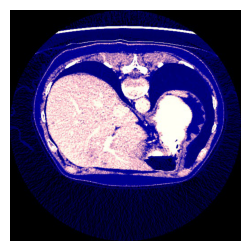

In [ ]:
# Preprocessing functions

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))


@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [ ]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :

    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:

    path = Path("/content/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/16 [00:00<?, ?it/s]

# **Training**

In [ ]:
bs = 16
im_size = 128
path = Path(".")
codes = np.array(["background","liver","tumor"])

def get_x(fname:Path): return fname
def label_func(x): return path/'/content/train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'/content/train_images')

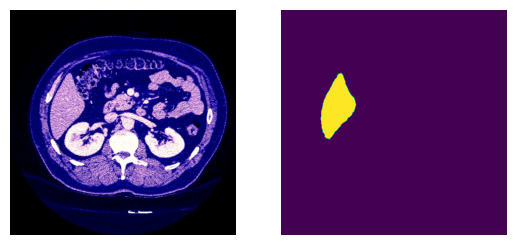

In [ ]:
idx=520
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [ ]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 262144]]


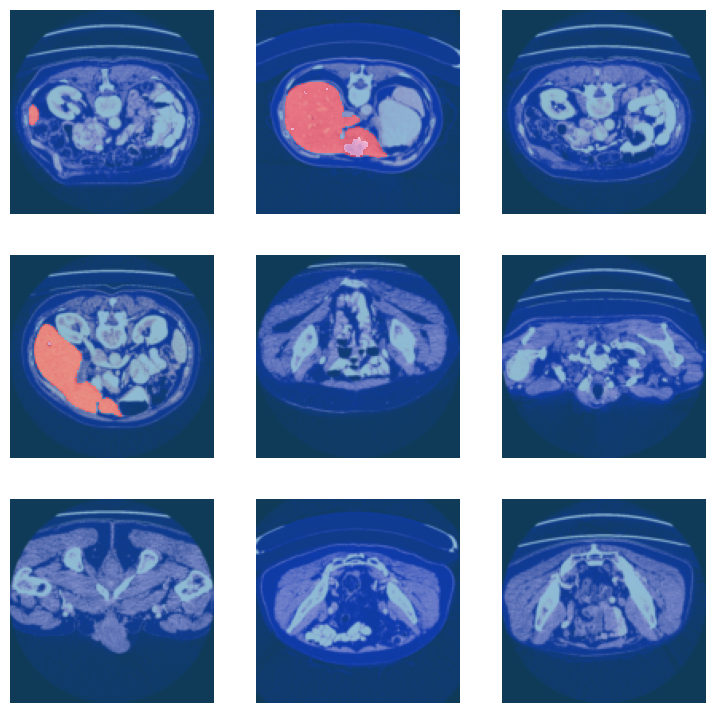

In [ ]:
dls = db.dataloaders(path/'/content/train_images',bs = bs) #, num_workers=0
dls.show_batch()

In [ ]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fine_tune(1, wd=0.1, cbs=SaveModelCallback() )

#done take it
#learn.unfreeze()
#learn.fit_one_cycle(1, lr_max=slice(1e-7, 1e-6))

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.017296,0.014983,0.958733,0.995394,1:09:10


Better model found at epoch 0 with valid_loss value: 0.014982955530285835.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.008491,0.005537,0.944281,0.998049,1:23:30


Better model found at epoch 0 with valid_loss value: 0.005537055432796478.


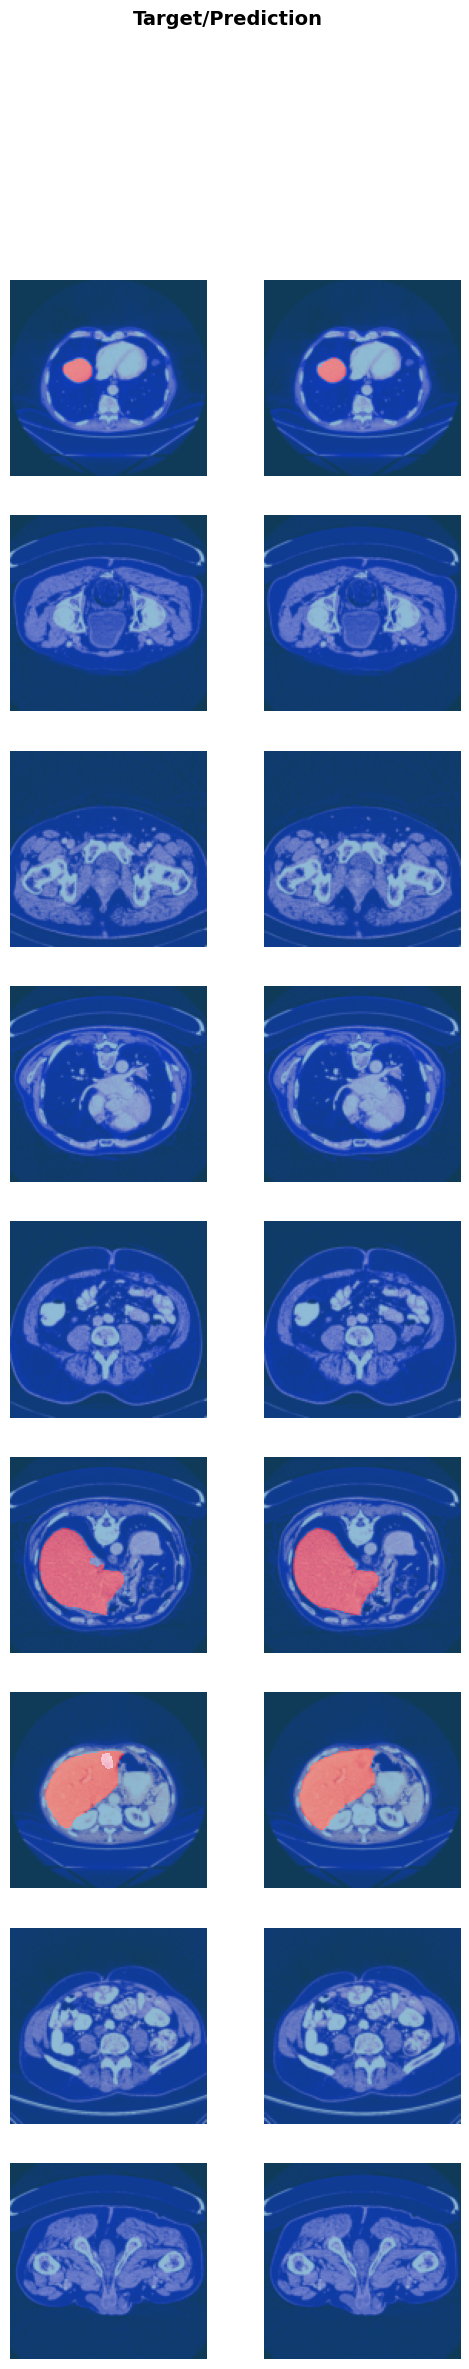

In [ ]:
learn.show_results()


In [ ]:
# Save the model
#/content/gdrive/MyDrive/Graduation Project /GP_FirstModels
learn.export(path/f'Liver_segmentation')

# **Testing**

In [ ]:
# Load saved model
if (GENERATE_JPG_FILES) :

    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    #/content/gdrive/MyDrive/Graduation Project /GP_FirstModels
    learn0               = load_learner(path/f'Liver_segmentation',cpu=False )
    learn0.dls.transform = tfms

NameError: ignored

In [ ]:
def nii_tfm(fn,wins):

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []

    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))

    return slices

In [ ]:
len(df_files)

46

In [ ]:
os.mkdir('/content/train_m/')
os.mkdir('/content/train_i/')
os.mkdir('/content/train_RGB_i/')

In [ ]:
for i in range(len(df_files)):
  test_nii   = read_nii(df_files.loc[i,'dirname']+"/"+df_files.loc[i,'filename'])
  test_mask  = read_nii(df_files.loc[i,'mask_dirname']+"/"+df_files.loc[i,'mask_filename'])

In [ ]:
counter = 0
for i in range(len(df_files)):

  for j in range(test_nii.shape[2]-1):
    r = test_mask[...,0]
    strnum = str(counter)
    counter = counter + 1
    sample_slice = tensor(test_nii[...,j].astype(np.float32))
    if test_mask[...,j].any()  != r.all():
      if test_nii[...,j].any() != r.all():

        plt.imsave('/content/train_m/' + 'Ei_slice'+strnum+'.png', test_mask[...,j])
        plt.imsave('/content/train_i/' + 'Ei_slice'+strnum+'.png', tensor([test_nii[...,j], test_mask[...,j]][0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone')
        plt.imsave('/content/train_RGB_i/' + 'Ei_slice'+strnum+'.png', tensor([test_nii[...,j], test_mask[...,j]][0].astype(np.float32)).windowed(*dicom_windows.liver))

In [ ]:
len(os.listdir('/content/train_m/'))

In [ ]:
counter

In [ ]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os

lst =[]
lst_image =[]
lst_RGB_image =[]

dir_m = '/content/train_m/'
dir_i = '/content/train_i/'
dir_RGB_i = '/content/train_RGB_i/'

# assign directory
directory = dir_m

# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        image_i = cv2.imread(f)
        original = image_i.copy()
        img = original

        # set red range
        lowcolor = (0,0,10)
        highcolor =(140, 144, 32)
        #cv2_imshow(img)
        # threshold
        thresh = cv2.inRange(img, lowcolor, highcolor)
        count = np.sum(np.nonzero(thresh))
        #print("Count = ",count)

        if count == 0:
            print("Not Tumor")
        else:
            print("Tumor Found")

        # Tumor Found
        if (count > 0):

          image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2HSV)
          lower = np.array([22, 93, 0], dtype="uint8")
          upper = np.array([45, 255, 255], dtype="uint8")
          mask = cv2.inRange(image_i, lower, upper)

          cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cnts = cnts[0] if len(cnts) == 2 else cnts[1]

          for c in cnts:
              x,y,w,h = cv2.boundingRect(c)
              cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

          ##print('Mask')
          ##cv2_imshow(mask)
          ##print('original')
          ##cv2_imshow(original)
          ##cv2.waitKey()


          (cnt, hierarchy) = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          rgb = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
          cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)


          imageCounter = 0
          plt.imsave('rgb'+str(imageCounter)+'.png',rgb)

          image_f= cv2.imread('/content/rgb'+str(imageCounter)+'.png')
          imageCounter = 1 + imageCounter
          original_image= image_f

          gray= cv2.cvtColor(image_f,cv2.COLOR_BGR2GRAY)

          edged= cv2.Canny(gray, 50,200)

          contours, hierarchy= cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

          print('image')
          cv2_imshow(image_f)
          cv2.waitKey(0)
          cv2.destroyAllWindows()


          def get_contour_areas(contours):

              all_areas= []
              r = 0
              cnt = ()
              for cnt in contours:
                  area= cv2.contourArea(cnt)
                  r = round(((area * 2.54) / 96), 2)
                  all_areas.append(r)

              return all_areas



          print('** Total Data ** \n Object Counter: ',len(cnt) ,"\n Objects size: ", get_contour_areas(cnt))
          lst.append([f, len(cnt) , get_contour_areas(cnt)])
          lst_image.append([os.path.join(dir_i, f[17:]), len(cnt) , get_contour_areas(cnt))
          lst_RGB_image.append([os.path.join(dir_RGB_i, f[17:]), len(cnt) , get_contour_areas(cnt)])

          cnt = tuple()
          contours = tuple()

          # No Tumor
        else:
          print('-****************No NO NO NON NO *********** \n ', f)
          cv2_imshow(original)
          lst.append([f, 0 , [0]])
          lst_image.append([os.path.join(dir_i, f[17:]), 0 , [0]])
          lst_RGB_image.append([os.path.join(dir_RGB_i, f[17:]), 0 , [0]])

In [ ]:
lst

In [ ]:
lst_image

In [ ]:
lst_RGB_image

In [ ]:
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class A/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class B/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class E/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class 0/')

os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class A/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class B/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class E/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class 0/')

os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class A/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class B/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class E/')
os.mkdir('/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class 0/')


In [ ]:
''' 1 <=2 => 0
    1 : 3 <=3 => A
    otherwise => B
    0 => E
'''
modelLabel = []

for i in range(len(lst)) :

    if lst[i][1] == 0:
      shutil.copy(lst_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class E/")
      shutil.copy(lst[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class E/")
      shutil.copy(lst_RGB_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class E/")

      modelLabel.append([lst_image[i][0], lst_RGB_image[i][0], lst[i][0], lst[i][1], lst[i][2], "E" ])

    elif lst[i][1] == 1 and max(lst[i][2]) <= 2:
      shutil.copy(lst_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class 0/")
      shutil.copy(lst[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class 0/")
      shutil.copy(lst_RGB_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class 0/")

      modelLabel.append([lst_image[i][0], lst_RGB_image[i][0], lst[i][0], lst[i][1], lst[i][2], "0" ])

    elif lst[i][1] >= 1 and lst[i][1] <= 3 and max(lst[i][2]) <= 3:
      shutil.copy(lst_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class A/")
      shutil.copy(lst[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class A/")
      shutil.copy(lst_RGB_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class A/")

      modelLabel.append([lst_image[i][0], lst_RGB_image[i][0], lst[i][0], lst[i][1], lst[i][2], "A" ])

    else:
      shutil.copy(lst_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_class B/")
      shutil.copy(lst[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_mask_class B/")
      shutil.copy(lst_RGB_image[i][0], "/content/gdrive/MyDrive/Graduation Project /GP_FirstModels/Ei_image_RGB_class B/")

      modelLabel.append([lst_image[i][0], lst_RGB_image[i][0], lst[i][0], lst[i][1], lst[i][2], "B" ])

In [ ]:
# importing the csv module
import csv

# field names
fields = ['Path Gray Image','Path RGB Image','Path Mask', 'Object Counter', 'Objects Size', 'Class']

# data rows of csv file
rows = modelLabel

# name of csv file
filename = "Ei_ModelLabels.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
	# creating a csv writer object
	csvwriter = csv.writer(csvfile)

	# writing the fields
	csvwriter.writerow(fields)

	# writing the data rows
	csvwriter.writerows(rows)


from csv import DictReader

# open file in read mode
with open("Ei_ModelLabels.csv", 'r') as f:

    dict_reader = DictReader(f)

    list_of_dict = list(dict_reader)

    print(list_of_dict)